In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("network_backup_dataset.csv")

In [3]:
def scaler_encoding(df):
    df["File Name"] = df["File Name"].str.split('_')
    df["File Name"] = df["File Name"].apply(lambda x: x[-1])
    
    df["Work-Flow-ID"] = df["Work-Flow-ID"].str.split('_')
    df["Work-Flow-ID"] = df["Work-Flow-ID"].apply(lambda x: x[-1])
    
    le = LabelEncoder()
    df["Day of Week"] = le.fit_transform(df["Day of Week"])
    return df,le

In [4]:
def one_hot_encoding(df):
    df['Day of Week'] = pd.Categorical(df['Day of Week'])
    dfDummies = pd.get_dummies(df['Day of Week'], prefix = 'category')
    df = pd.concat([df, dfDummies], axis=1)

    df['Work-Flow-ID'] = pd.Categorical(df['Work-Flow-ID'])
    dfDummies = pd.get_dummies(df['Work-Flow-ID'], prefix = 'category')
    df = pd.concat([df, dfDummies], axis=1)
    
    df['File Name'] = pd.Categorical(df['File Name'])
    dfDummies = pd.get_dummies(df['File Name'], prefix = 'category')
    df = pd.concat([df, dfDummies], axis=1)
    
    return df.drop(['Day of Week', 'Work-Flow-ID','File Name'], axis=1)

In [5]:
df_scaler_encoded,le = scaler_encoding(df)
df_onehot_encoded = one_hot_encoding(df)

2.Predict the backup size of a file given the other attributes. We use all attributes,
except Backup Time, as candidate features for the prediction of backup size.
We will try different feature sets, as well as different encoding schemes for each
feature and in combination. For example, each of the following five features is
a categorical variable: Day of the Week, Hour of the Day, Work-flow-ID, File
Name, and Week Number.

For each categorical variable, we could convert it into a one dimensional numerical
value. For example, Day of the Week variable could take values 1;    ; 7 corresponding to Monday through Sunday. Similarly, the Hour of the Day could be encoded as 1;    ; 24. We will refer to this as a scalar encoding.
For each categorical variable that takes one of M values we can also encode it as
an M dimensional vector, where only one entry is 1 and the rest are 0's. Thus for
the Day of the Week, Monday could be encoded as [1; 0; 0; 0; 0; 0; 0] and Sunday as
[0; 0; 0; 0; 0; 0; 1]. We will refer to this encoding as one-hot-encoding.
For part (a)-(e), in each part you will use one type of models to predict the backup
sizes.

In each part, you need to report training and test Root Mean Squared Error
(RMSE) from 10-fold cross validation as the basic evaluation of the performance. That is, for each fold you get two numbers: training RMSE and test RMSE.
In addition, you need to plot the following two types of plots using the whole
dataset for each part with the best parameters and hyper-parameters found for
the model (use RMSE as the standard for the selection of the \best"):
i Plot fitted values against true values as scatter plots
ii Plot residuals versus fitted values as scatter plots
These plots visualize how well your models fit the data.

(a) Fit a linear regression model. We use ordinary least square as the penalty
function.
Convert each categorical feature into one dimensional numerical values using
scalar encoding (e.g. Monday to Sunday can be mapped to 1-7), and then
directly use them to fit a basic linear regression model.

In [6]:
def plot_ground_vs_fitted(y_true,y_pred):
    fig = plt.figure()  
    plt.scatter(range(len(y_true)),y_true,marker='x',label='Ground Truth')
    plt.scatter(range(len(y_pred)),y_pred,label='Fitted Truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()
    
def plot_residual_vs_fitted(y_true,y_pred):
    fig = plt.figure()  
    y_res = np.array(y_true)-np.array(y_pred)
    plt.scatter(range(len(y_res)),y_res,marker='x',label='Residual')
    plt.scatter(range(len(y_pred)),y_pred,label='Fitted Truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

In [7]:
def cross_validation_testing(model,X,y,plot=True):
    kf = KFold(n_splits=10)
    rmse_train, rmse_test = 0, 0
    rmse_train_list, rmse_test_list = [],[]
    y_pred = []
    y_true = []

    # clf = LinearRegression()
    # scores = cross_val_score(clf, X, y, cv=10, scoring="neg_mean_squared_error")
    # print(scores.mean())

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        model.fit(X_train, y_train)
        rmse_train_list.append(mean_squared_error(y_train, model.predict(X_train)))
        rmse_test_list.append(mean_squared_error(y_test,model.predict(X_test)))
        y_pred+=list(model.predict(X_test))
        y_true+=list(y_test)

    rmse_train = np.sqrt(np.mean(rmse_train_list))
    rmse_test = np.sqrt(np.mean(rmse_test_list))
    if plot:
        plot_ground_vs_fitted(y_true,y_pred)
        plot_residual_vs_fitted(y_true,y_pred)
    return rmse_train,rmse_test,model

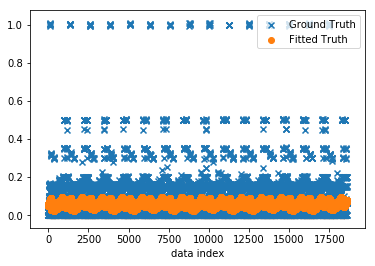

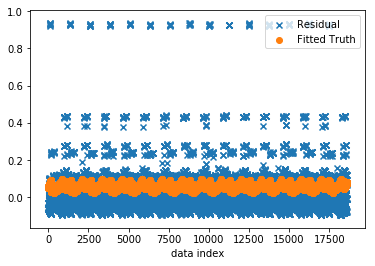

In [8]:
# Linear Regression
from sklearn.model_selection import cross_val_score
X = df_scaler_encoded.drop(['Size of Backup (GB)','Backup Time (hour)'],axis = 1)
y = df_scaler_encoded['Size of Backup (GB)']
rmse_train,rmse_test,_ = cross_validation_testing(LinearRegression(),X,y)

In [9]:
print(rmse_train, rmse_test)

0.10306535429614527 0.10316544988003133


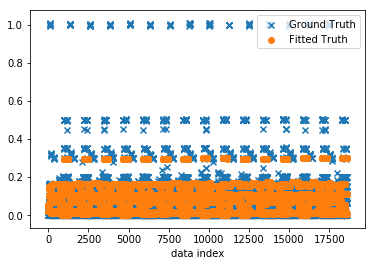

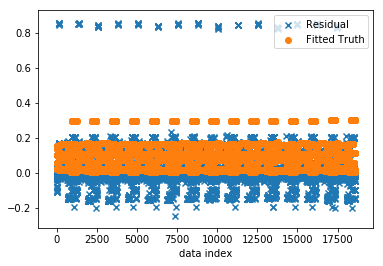

In [10]:
from sklearn.ensemble import RandomForestRegressor

X = df_scaler_encoded.drop(['Size of Backup (GB)','Backup Time (hour)'],axis = 1)
y = df_scaler_encoded['Size of Backup (GB)']

regr = RandomForestRegressor(max_depth=4, random_state=0, bootstrap = True,max_features=5,
                              n_estimators=20,oob_score=True)
rf_rmse_train, rf_rmse_test,model = cross_validation_testing(regr,X,y)
oob_error = 1- model.oob_score_


In [11]:
print(rf_rmse_train, rf_rmse_test, oob_error)

0.07582598831582459 0.07605040868543311 0.5314969255914614


In [53]:
oob_error_list = []
rmse_test_list = []
min_rmse = 100000
for i in range(1,201):
    print("For ",i, " number of trees")
    oob_error = 0
    rmse_test = 0
    for j in range(1,6):
        print("For ",j, " number of features")
        regr = RandomForestRegressor(max_depth=4, random_state=0, bootstrap = True,max_features=j,
                              n_estimators=i,oob_score=True)
        rf_rmse_train, rf_rmse_test,model = cross_validation_testing(regr,X,y,plot=False)
        oob_error += (1- model.oob_score_)
        rmse_test += rf_rmse_test
        if rf_rmse_test<min_rmse:
            min_rmse = rf_rmse_test
            best_model = regr
    oob_error_list.append(oob_error/5)
    rmse_test_list.append(rmse_test/5)


For  1  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  2  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  3  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  4  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  5  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  6  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  7  number of trees
For  1  number of feat

For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  53  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  54  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  55  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  56  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  57  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  58  number of trees
For  1  number of features
For  2  number of features
For  3  numbe

For  4  number of features
For  5  number of features
For  104  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  105  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  106  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  107  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  108  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  109  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5 

For  4  number of features
For  5  number of features
For  155  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  156  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  157  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  158  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  159  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  160  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5 

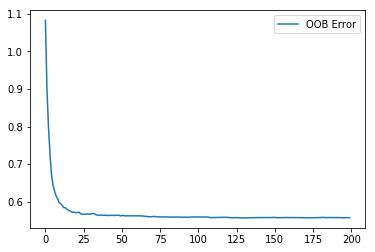

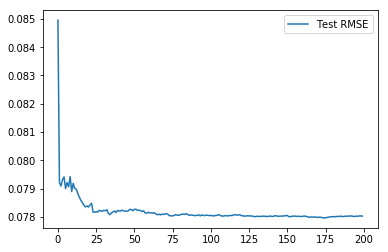

In [54]:
plt.plot(range(len(oob_error_list)),oob_error_list,label="OOB Error")
plt.legend(loc='upper right')
plt.show()

plt.plot(range(len(rmse_test_list)),rmse_test_list,label="Test RMSE")
plt.legend(loc='upper right')
plt.show()

In [55]:
print(np.min(oob_error_list),np.argmin(oob_error_list))


0.5568336746334985 129


In [56]:
print(np.min(rmse_test_list),np.argmin(rmse_test_list))

0.07796375587464872 174


In [57]:
best_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=6, n_jobs=None, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

In [58]:
min_rmse

0.07448425009163814

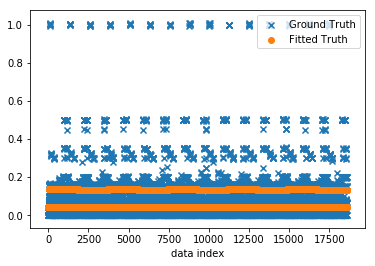

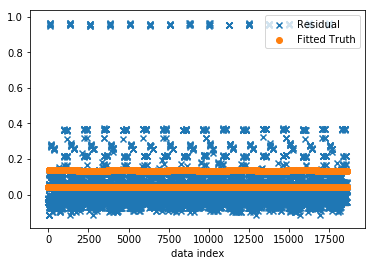

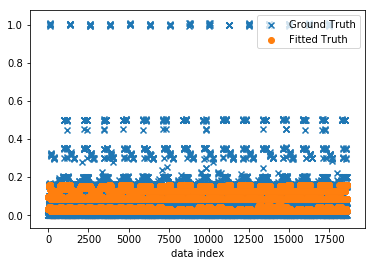

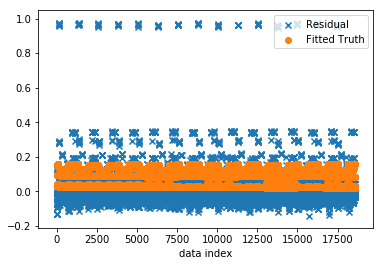

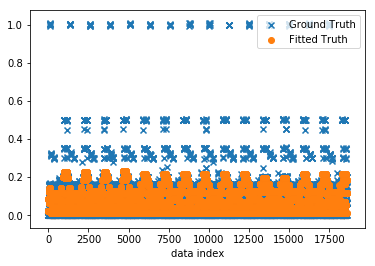

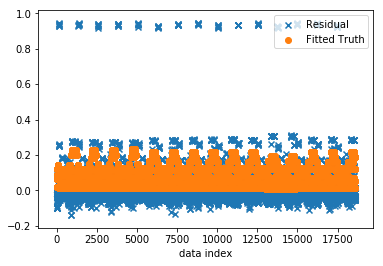

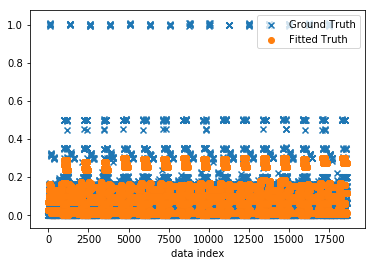

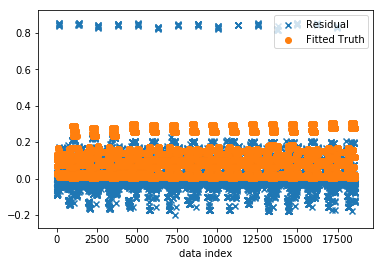

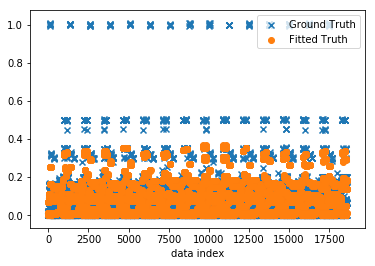

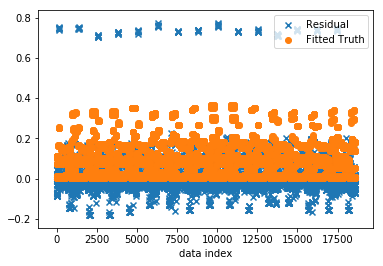

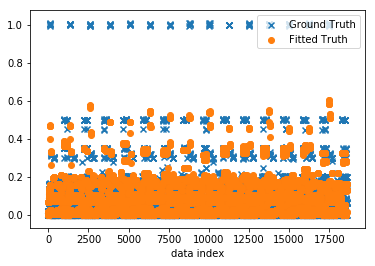

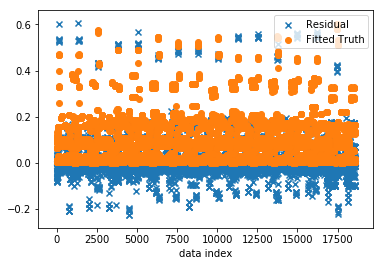

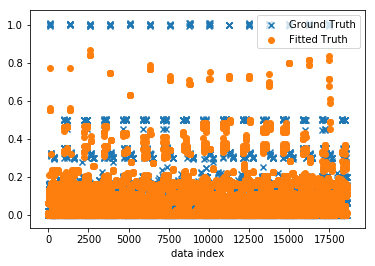

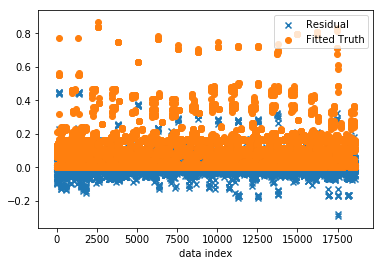

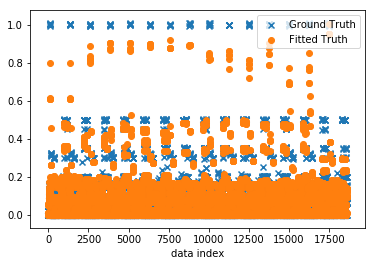

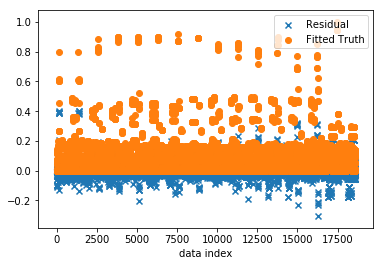

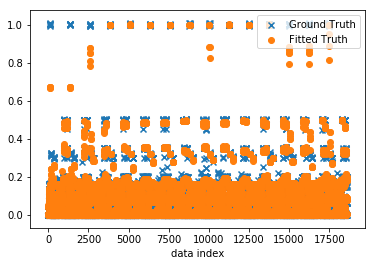

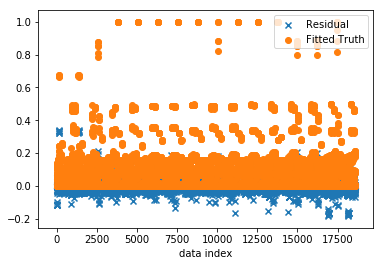

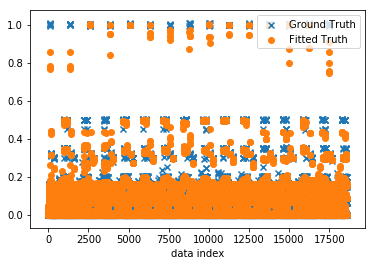

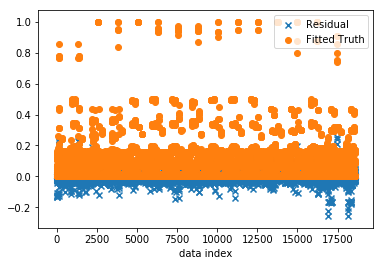

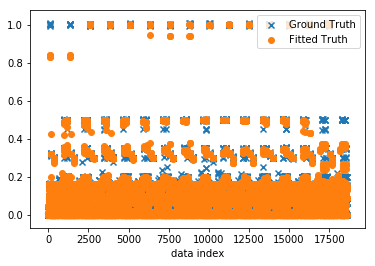

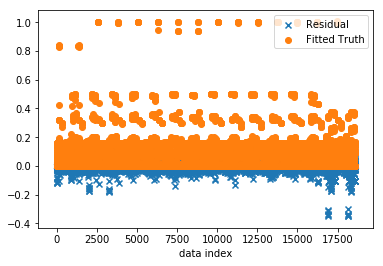

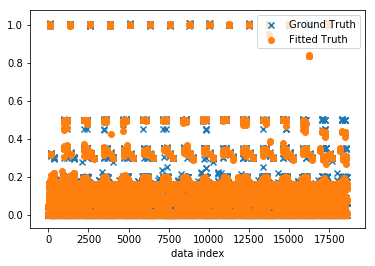

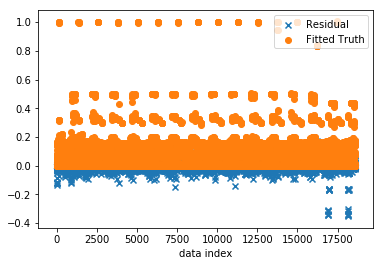

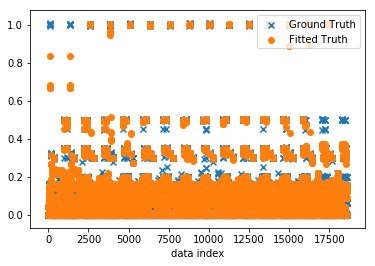

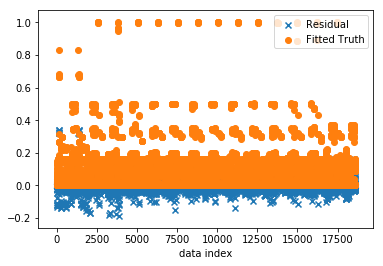

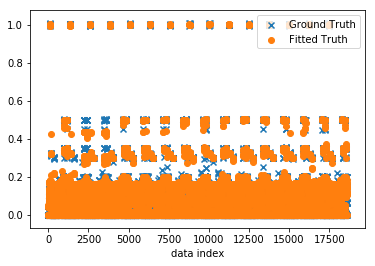

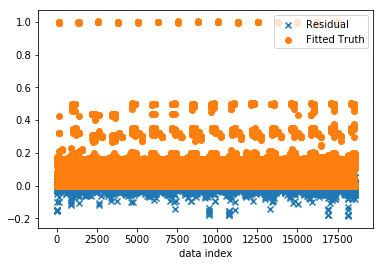

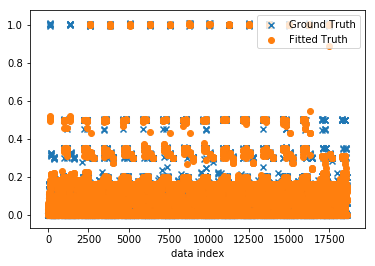

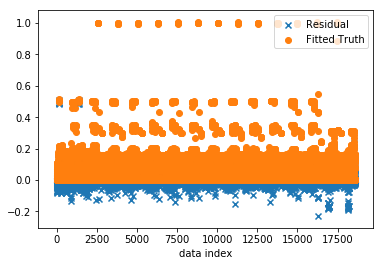

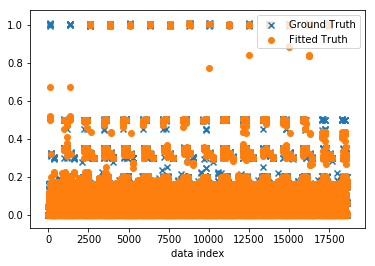

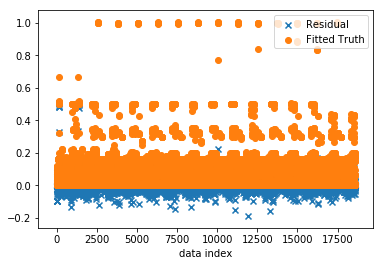

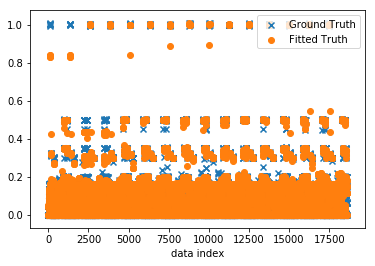

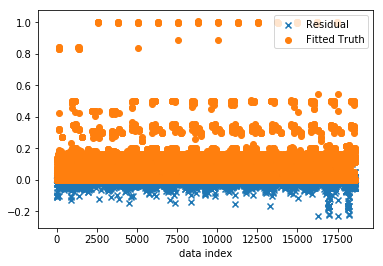

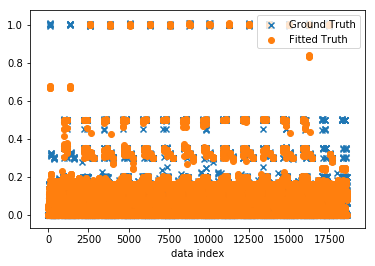

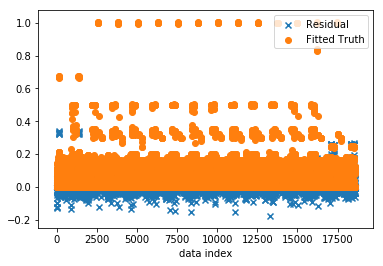

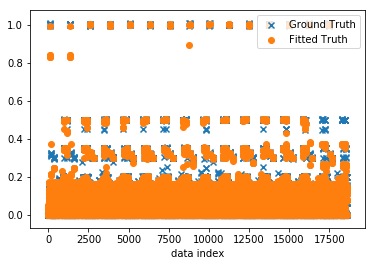

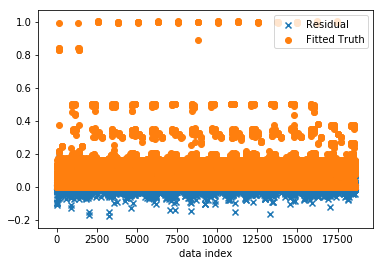

In [59]:
# Experimenting on max_depth
# Sweeping from 1 to 10, with other parameters fixed
oob_error_list = []
rmse_test_list = []
min_rmse = 10000
for i in range(1,20):
    regr = RandomForestRegressor(max_depth=i, random_state=0, bootstrap = True,max_features=3,
                              n_estimators=6,oob_score=True)
    rf_rmse_train, rf_rmse_test,model = cross_validation_testing(regr,X,y)
    if rf_rmse_test<min_rmse:
        min_rmse = rf_rmse_test
        best_model_2 = regr
    oob_error_list.append(1 - model.oob_score_)
    rmse_test_list.append(rf_rmse_test)

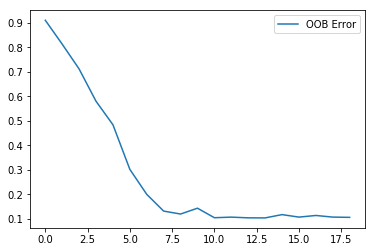

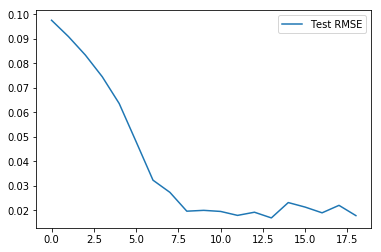

In [60]:
plt.plot(range(len(oob_error_list)),oob_error_list,label="OOB Error")
plt.legend(loc='upper right')
plt.show()

plt.plot(range(len(rmse_test_list)),rmse_test_list,label="Test RMSE")
plt.legend(loc='upper right')
plt.show()

In [61]:
print(np.min(rmse_test_list),np.argmin(rmse_test_list))

0.016906376230641746 13


In [62]:
best_model_2

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=6, n_jobs=None, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

### 2.b.iv. Report the feature importances you got from the best random forest regression you find.

In [63]:
best_model_2.feature_importances_

array([0.00836884, 0.42830097, 0.27595823, 0.08511047, 0.20226149])

### 2.b.v Visualize your decision trees.

In [64]:

estimator = best_model.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator,out_file="tree.dot",
                feature_names=X.columns,
                filled=True,
                rounded=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
import os
# Install Graphviz and restart jupyter for this line to run
os.system('dot -Tpng tree.dot -o tree.png')




1

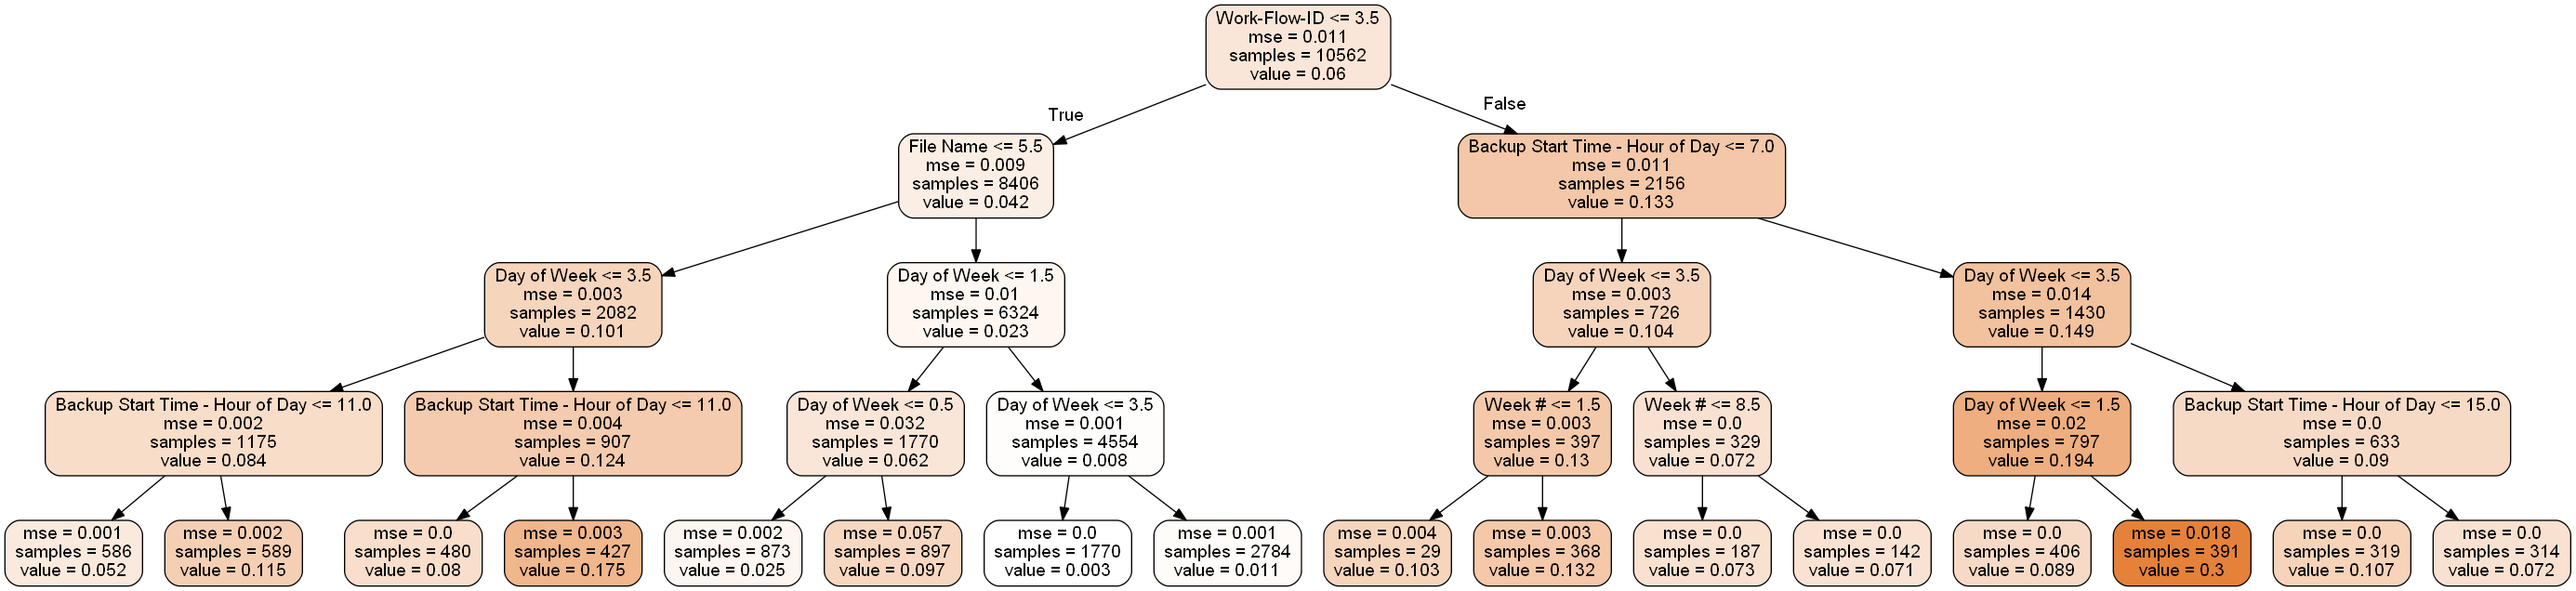

In [66]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')